# Machine Learning- reconstruct Image from partial/incomplete image

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
from keras.layers import Layer, Input, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
from keras_contrib.layers.normalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.backend import mean
from keras.models import Model, model_from_json
from keras.utils import plot_model
from keras.engine.topology import Container

from collections import OrderedDict
from scipy.misc import imsave, toimage  # has depricated
import numpy as np
import random
import datetime
import time
import json
import math
import csv
import sys
import os

import keras.backend as K
import tensorflow as tf

## 1/ Extract information from incomplete image

In [ ]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [ ]:
import nibabel as nib
import numpy as np

In [ ]:
image = nib.load

In [ ]:
import os
import numpy as np
from PIL import Image
from keras.utils import Sequence
#from skimage.io import imread


def load_data(nr_of_channels, batch_size=1, nr_A_train_imgs=None, nr_B_train_imgs=None,
              nr_A_test_imgs=None, nr_B_test_imgs=None, subfolder='',
              generator=False, D_model=None, use_multiscale_discriminator=False, use_supervised_learning=False, REAL_LABEL=1.0):

    trainA_path = os.path.join('data', subfolder, 'trainA')
    trainB_path = os.path.join('data', subfolder, 'trainB')
    testA_path = os.path.join('data', subfolder, 'testA')
    testB_path = os.path.join('data', subfolder, 'testB')

    trainA_image_names = os.listdir(trainA_path)
    if nr_A_train_imgs != None:
        trainA_image_names = trainA_image_names[:nr_A_train_imgs]

    trainB_image_names = os.listdir(trainB_path)
    if nr_B_train_imgs != None:
        trainB_image_names = trainB_image_names[:nr_B_train_imgs]

    testA_image_names = os.listdir(testA_path)
    if nr_A_test_imgs != None:
        testA_image_names = testA_image_names[:nr_A_test_imgs]

    testB_image_names = os.listdir(testB_path)
    if nr_B_test_imgs != None:
        testB_image_names = testB_image_names[:nr_B_test_imgs]

    if generator:
        return data_sequence(trainA_path, trainB_path, trainA_image_names, trainB_image_names, batch_size=batch_size)  # D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL)
    else:
        trainA_images = create_image_array(trainA_image_names, trainA_path, nr_of_channels)
        trainB_images = create_image_array(trainB_image_names, trainB_path, nr_of_channels)
        testA_images = create_image_array(testA_image_names, testA_path, nr_of_channels)
        testB_images = create_image_array(testB_image_names, testB_path, nr_of_channels)
        return {"trainA_images": trainA_images, "trainB_images": trainB_images,
                "testA_images": testA_images, "testB_images": testB_images,
                "trainA_image_names": trainA_image_names,
                "trainB_image_names": trainB_image_names,
                "testA_image_names": testA_image_names,
                "testB_image_names": testB_image_names}


def create_image_array(image_list, image_path, nr_of_channels):
    image_array = []
    for image_name in image_list:
        if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
            if nr_of_channels == 1:  # Gray scale image -> MR image
                image = np.array(Image.open(os.path.join(image_path, image_name)))
                image = image[:, :, np.newaxis]
            else:                   # RGB image -> 3 channels
                image = np.array(Image.open(os.path.join(image_path, image_name)))
            image = normalize_array(image)
            image_array.append(image)

    return np.array(image_array)
  
  
  # If using 16 bit depth images, use the formula 'array = array / 32767.5 - 1' instead
def normalize_array(array):
    array = array / 127.5 - 1
    return array


class data_sequence(Sequence):

    def __init__(self, trainA_path, trainB_path, image_list_A, image_list_B, batch_size=1):  # , D_model, use_multiscale_discriminator, use_supervised_learning, REAL_LABEL):
        self.batch_size = batch_size
        self.train_A = []
        self.train_B = []
        for image_name in image_list_A:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_A.append(os.path.join(trainA_path, image_name))
        for image_name in image_list_B:
            if image_name[-1].lower() == 'g':  # to avoid e.g. thumbs.db files
                self.train_B.append(os.path.join(trainB_path, image_name))

    def __len__(self):
        return int(max(len(self.train_A), len(self.train_B)) / float(self.batch_size))

    def __getitem__(self, idx):  # , use_multiscale_discriminator, use_supervised_learning):if loop_index + batch_size >= min_nr_imgs:
        if idx >= min(len(self.train_A), len(self.train_B)):
            # If all images soon are used for one domain,
            # randomly pick from this domain
            if len(self.train_A) <= len(self.train_B):
                indexes_A = np.random.randint(len(self.train_A), size=self.batch_size)
                batch_A = []
                for i in indexes_A:
                    batch_A.append(self.train_A[i])
                batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]
            else:
                indexes_B = np.random.randint(len(self.train_B), size=self.batch_size)
                batch_B = []
                for i in indexes_B:
                    batch_B.append(self.train_B[i])
                batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
        else:
            batch_A = self.train_A[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_B = self.train_B[idx * self.batch_size:(idx + 1) * self.batch_size]

        real_images_A = create_image_array(batch_A, '', 3)
        real_images_B = create_image_array(batch_B, '', 3)

        return real_images_A, real_images_B  # input_data, target_data

In [ ]:
def extractInformation(image):
    cv2
    return

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


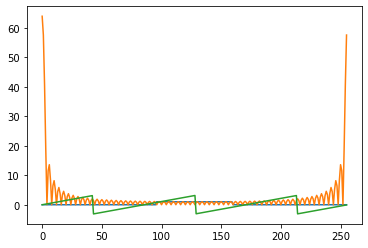

In [1]:
import numpy as np
import matplotlib.pyplot as plt

mx = np.zeros([256,1])
mx[96:128+32] = 1
plt.plot(mx)

ksp = np.fft.fft(mx,axis=0)
plt.plot(np.abs(ksp))

k = np.zeros(ksp.shape);

# voxel #2 and #3 were mis-placed using an imperfect gradient 
k[3] = ksp[3]+ksp[2]; 

rec = np.fft.ifft(k,axis=0);
phase = np.angle(rec)
# it's a straight line after unwrapping
plt.plot(np.angle(rec)) 

In [ ]:
import pydicom as dicom
import PIL # optional
import pandas as pd
import matplotlib.pyplot as plt

# specify your image path
image_path = 'xray.dcm'
ds = dicom.dcmread(image_path)
plt.imshow( ds.pixel_array)

plt.show()